# Set up plates for a duckweed genotypes x media growth assay

## 0. Import packages and libraries

In [26]:
import pandas as pd
import os
import json
import time
import ipywidgets as widgets
import utils.PlatePositionUtils as pp 
import utils.DuckbotExptSetupUtils as exp


In [8]:
#This cell will only run if you are working at a computer connected to the Jubilee
from utils.CameraUtils import *
from utils.MachineUtils import *
port = "/dev/ttyACM0"
m = MachineCommunication(port)

## 1. Select config files

### Select config file location

In [2]:
config_file_dirs = ['/Users/Orlando/Documents/Github_clones/duckbot/ConfigFiles', 
                     "/home/pi/Documents/Data/ConfigFiles"]

config_dir_opts = config_file_dirs
dir_choice = widgets.Dropdown(options = config_dir_opts)
display(dir_choice)

Dropdown(options=('/Users/Orlando/Documents/Github_clones/duckbot/ConfigFiles', '/home/pi/Documents/Data/Confi…

In [3]:
expt_config_file_dir = os.path.join(dir_choice.value,'ExptConfigs')
labware_config_file_dir = os.path.join(dir_choice.value,'HardwareLabwareConfigs')

### Select  Hadware-Labware config file

In [4]:
os.chdir(labware_config_file_dir)
config_opts = os.listdir(os.getcwd())
hl_choice = widgets.Dropdown(options = config_opts)
display(hl_choice)

Dropdown(options=('Default.json',), value='Default.json')

In [7]:
with open(hl_choice.value,'r') as datafile:
    hardwarelabwareconfig = json.load(datafile)
media_reservoir = hardwarelabwareconfig['media_reservoir']
tool_positions = hardwarelabwareconfig['tool_positions']
dispense_calcs = hardwarelabwareconfig['dispense_calcs']
z_dict = hardwarelabwareconfig['z_dict']
inoculation_loop_z_dict = hardwarelabwareconfig['z_dict']
dispense_offset =  dispense_calcs['dispense_mL'] * dispense_calcs['vol_conversion']
dispenses_per_sringe_fill = dispense_calcs['dispenses_per_syringe_fill']
duckweed_reservoir_loc = hardwarelabwareconfig["duckweed_reservoir_loc"]

### Select, visualize and confirm experimental config file

In [15]:
os.chdir(expt_config_file_dir)
config_opts = os.listdir(os.getcwd())
expt_choice = widgets.Dropdown(options = config_opts)
display(expt_choice)

Dropdown(options=('Test_082422.json', 'Expt_082222.json', 'Test_expt.json', '.ipynb_checkpoints', 'Test_082422…

#### Run this cell to print a visualization of your experimental design. If this isn't as expected go back and re-run the config file selection cell or go back and directly edit your experimental config file and start again

In [20]:
expt_setup_filepath = expt_config_file_dir + '/' + expt_choice.value

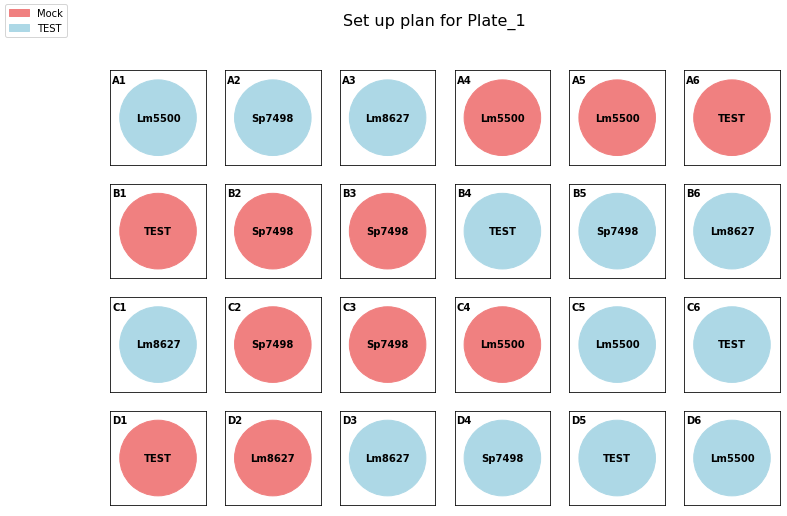

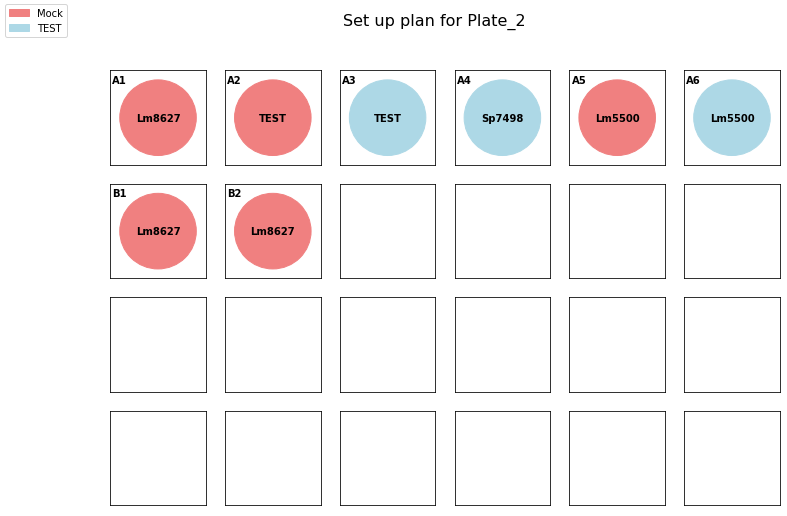

In [27]:
with open(expt_setup_filepath,'r') as datafile:
    expt_data = json.load(datafile)
    
# Turn samples list into a dataframe
sample_data_dict = expt_data["sample_info"]

df_with_well_coords = pp.add_well_coords_to_df_from_sample_data_dict(sample_data_dict)
exp.visualize_plate_set_up(df_with_well_coords)

## 2. Label 24-well plates and add to machine
Follow the instructions that are printed when you run the cells

#### Label Plates and add plates to machine

In [10]:
df = pd.DataFrame(sample_data)
num_plates = df.Plate.nunique()
print(num_plates)

print("This experiment requires {} 24-well plate(s)".format(num_plates))
print("----")
lst = list(range(1,num_plates + 1))
for n in lst:
    print("Label a plate with experiment ID or initials and 'plate {}'".format(n))
print("----")
print ("Place the 24-well plate(s) in the jubilee".format(num_plates))
print ("Start at position 1 and fill empty plate slots in order")

2
This experiment requires 2 24-well plate(s)
----
Label a plate with experiment ID or initials and 'plate 1'
Label a plate with experiment ID or initials and 'plate 2'
----
Place the 24-well plate(s) in the jubilee
Start at position 1 and fill empty plate slots in order


## 3. Dispense media
Run cells, making sure to follow the instructions that print when your run the cells

In [16]:
#Retrieve absolute positions of wells from a library and then add those coordinatest to the plate set up dataframe
df_with_well_coords = pp.add_well_coords_to_df_from_sample_data_dict(sample_data_dict)

#Reorganizes dataframe to create machine instructions sorted by media-type
media_dicts = pp.pull_list_of_well_coord_dicts_by_dfcolumn(df_with_well_coords, 'media')

In [29]:
#Pick up syringe toolhead
port = "/dev/ttyACM0"
m = MachineCommunication(port)
m.toolChange(media_syringe)

In [20]:
# Send machine instructions

for media in media_dicts:
    m.moveTo(x=0,y=0,z=0)
    print(f"Please ensure {media['media']} is available in the machine before continuing.")
    print("Change syringe and/or needle if desired")
    while True:
        value = input("Enter 'YES' to confirm that the correct media is in position")
        if value != "YES":
            print("Please confirm")
        else:
            break
    exp.dispense_to_wells(m, media["well-coords"], dispense_offset, dispenses_per_syringe_fill, media_reservoir, z_dict)

## 4. Transfer duckweed

### Transfer option 1: Automated transfer with inoculation loop

In [31]:
#pop the bed down to avoid any collisions on tool change
m.moveTo(z=50)

In [32]:
# pick up the innoculation loop
m.toolChange(inoculation_loop)
m.moveTo(x=duckweed_reservoir[0], y=duckweed_reservoir[1])

In [ ]:
# pop the bed down to avoid collisions after probing 
m.moveTo(z=50)

In [ ]:
# Inoculation Loop Transfer
# The machine will move after running this cell
exp.inoculation_loop_transfer(m, df, duckweed_reservoir, inoculation_loop_z_dict)

In [34]:
# pop bed down to access labware
m.moveTo(z=100)

Place container of duckweed type **Lm5500** into jubilee and ensure lid is open
Type anything into the input field to confirm that the media is available.
    After this point the Jubilee will begin dispensing
excelsior
Place container of duckweed type **Lm8627** into jubilee and ensure lid is open
Type anything into the input field to confirm that the media is available.
    After this point the Jubilee will begin dispensing
I hope this one works
Place container of duckweed type **Sp7498** into jubilee and ensure lid is open
Type anything into the input field to confirm that the media is available.
    After this point the Jubilee will begin dispensing
spirodela for the win


### Consecutive Tranfser Passes
These cells will find any wells missing duckweed, and then prompt you to swap in the appropriate duckweed reservoir for transfer. Re-run the cells as many times as you like until you are satisfied with the results

In [ ]:
m.toolChange(1)
exp.check_wells(m, df)

In [ ]:
exp.fill_empty_wells(m, df, duckweed_reservoir, inoculation_loop_z_dict)

### Transfer option 2: Manual transfer
Run this cell to generate written instructions of what duckweed genotypes should be in which wells. 

In [ ]:
#Manual transfer

grouped_df = df.groupby('genotype')
for field_value, sample_df in grouped_df:
    print("Place container of duckweed type **{0}** into jubilee and ensure lid is open".format(field_value))
    for index,s in sample_df.iterrows():
        plate = s["Plate"]
        well = s["Well"]
        print(f"Transfer {field_value} to plate {plate}, well {well}")
    input()
        #print("Dispensing media of type {0} into {1}, well {2}".format(field_value,s["Plate"], s["Well"]))


Place container of duckweed type **Lm5500** into jubilee and ensure lid is open
Transfer Lm5500 to plate Plate_1, well A6
Transfer Lm5500 to plate Plate_1, well B2
Transfer Lm5500 to plate Plate_1, well B3
Transfer Lm5500 to plate Plate_1, well B5
Transfer Lm5500 to plate Plate_1, well B6
Transfer Lm5500 to plate Plate_1, well C2
Transfer Lm5500 to plate Plate_2, well A1
Transfer Lm5500 to plate Plate_2, well A5
Transfer Lm5500 to plate Plate_2, well B2
Transfer Lm5500 to plate Plate_2, well B4
Transfer Lm5500 to plate Plate_2, well C1
Transfer Lm5500 to plate Plate_2, well C5
Transfer Lm5500 to plate Plate_2, well C6
Transfer Lm5500 to plate Plate_2, well D3
Transfer Lm5500 to plate Plate_3, well A1
Transfer Lm5500 to plate Plate_3, well A2
Transfer Lm5500 to plate Plate_3, well A5
Transfer Lm5500 to plate Plate_3, well A6
Transfer Lm5500 to plate Plate_3, well B2
Transfer Lm5500 to plate Plate_3, well B3

Place container of duckweed type **Lm8627** into jubilee and ensure lid is open

#### Record any extra notes you'd like to add
Write down any notes about today's set up that you would like to be recorded in the set up file 

In [ ]:
notes = input()
exp.add_input_to_json(notes, "Set_up_notes", expt_setup_filepath)